# Stuur robot naar het object

> Uit vorige opdrachten hebben we de positie van een target, gezien vanuit de camera, kunnen definiëren in robot frame. We zijn dus de transformatie ${}^{B}T_{T}$ bekomen. Dit is de positie waar de robot naartoe moet bewegen. Uit de voorwaartse kinematica van een robot weten we dat als we de joint-coördinaten $q$ van een robot kennen, we de voorwaartste transformatie kunnen bepalen, m.a.w. de positie van de end-effector beschreven in het baselink frame. Deze positie wordt voorgesteld door de transformatiematrix van het baselinkframe {B} naar het end-effector frame {ee} zijnde ${}^{B}T_{ee}$. Het doel is dus om de joint-coördinaten zodanig te berekenen dat ${}^{B}T_{ee}$ gelijk wordt aan ${}^{B}T_{T}$. Dit zullen we doen gebruik makende van de inverse kinematica van de robot. 



# 1. Import libraries

> Deze bibliotheken zijn nodig voor het volbrengen van dit script. In de CameraCalibration bibliotheek vind je de code achter de commando's die je hier zal gebruiken. 



In [ ]:
import sys
from math import *
sys.path.append('/content/drive/My Drive/object_pose_estimation_online')
from Classes.Visualization import *
from Classes.CameraCalibration import *

# 2. Laden van de berekende baselink-target transformatiematrix die de positie van het target beschrijft in robot baselinkframe

In [ ]:
# Import baselink-target transformation matrix (numpy data)
mean_baselink_target_transformation_file = '/content/drive/My Drive/object_pose_estimation_online/data/matrix_files/mean_baselink_target_transformation.npy'
bt_transform = get_numpy_data(mean_baselink_target_transformation_file)
print(bt_transform)

[[ 0.58351947 -0.80918351  0.06875367  0.01655894]
 [-0.80274843 -0.58754032 -0.10193785 -0.6524284 ]
 [ 0.12288198  0.00429082 -0.99241202 -0.03726128]
 [ 0.          0.          0.          1.        ]]


# 3. Definiëren van de voorwaartse kinematica

> De voorwaartse kinematica vertaalt de joint-coördinaten $q$ naar de positie van de end-effector in baselinkframe ${}^{B}T_{ee}$. Dit bestaat uit een aaneenschakeling van transformatiematrices die elk de verplaatsing voorstellen ten gevolge van één joint. De matrix ${}^{b}T_{1}$ stelt de transformatie voor van baselink naar joint 1 {1} en wordt beïnvloed door de eerste joint-waarde $q[0]$. De matrix ${}^{1}T_{2}$ stelt de transformatie voor van joint 1 naar joint 2 {2} en wordt beïnvloed door de tweede joint-waarde $q[1]$. En zo voort tot we aan de end-effector uitkomen. De functie "robot_kinematics" neemt joint variabelen (6 voor deze 6dof robot) en geeft de totale matrix ${}^{B}T_{ee}$ terug. 



In [ ]:
def robot_kinematics(q):

    Tb1 = sp.Matrix([[-sp.cos(q[0]), 0, -sp.sin(q[0]), 0.050 * sp.cos(q[0])],
                     [-sp.sin(q[0]), 0, sp.cos(q[0]), 0.050 * sp.sin(q[0])],
                     [0, 1, 0, 0.457],
                     [0, 0, 0, 1]])

    T12 = sp.Matrix([[-sp.sin(q[1]), -sp.cos(q[1]), 0, -0.440 * sp.sin(q[1])],
                     [sp.cos(q[1]), -sp.sin(q[1]), 0, 0.440 * sp.cos(q[1])],
                     [0, 0, 1, 0],
                     [0, 0, 0, 1]])

    T23 = sp.Matrix([[-sp.cos(q[2]), 0, -sp.sin(q[2]), 0.035 * sp.cos(q[2])],
                     [-sp.sin(q[2]), 0, sp.cos(q[2]), 0.035 * sp.sin(q[2])],
                     [0, 1, 0, 0],
                     [0, 0, 0, 1]])

    T34 = sp.Matrix([[-sp.cos(q[3]), 0, -sp.sin(q[3]), 0],
                     [-sp.sin(q[3]), 0, sp.cos(q[3]), 0],
                     [0, 1, 0, 0.420],
                     [0, 0, 0, 1]])

    T45 = sp.Matrix([[-sp.cos(q[4]), 0, -sp.sin(q[4]), 0],
                     [-sp.sin(q[4]), 0, sp.cos(q[4]), 0],
                     [0, 1, 0, 0],
                     [0, 0, 0, 1]])

    T5ee = sp.Matrix([[sp.cos(q[5]), -sp.sin(q[5]), 0, 0],
                     [sp.sin(q[5]), sp.cos(q[5]), 0, 0],
                     [0, 0, 1, 0],
                     [0, 0, 0, 1]])

    bTee = Tb1 * T12 * T23 * T34 * T45 * T5ee

    return np.array(bTee).astype(np.float64)

# 4. Berekenen van de gewenste joint variabelen met inverse kinematica

> De inverse kinematica wordt berekend door middel van numerieke wiskunde. Een optimalisatieproces wordt uitgevoerd en probeert een kostfunctie te minimaliseren door enkel de joint variabelen te veranderen. De kost functie is hier de error tussen de positie waar de robot zich huidig bevindt ${}^{B}T_{ee}$ en de gewenste positie ${}^{B}T_{T}$. Je kan zien dat de doelfunctie "distance_to_target" een set joint variablelen inleest alsook de doelpositie. Eerst wordt de voorwaartse kinematica berekend. Vervolgens word de positie en orientatie error apart berekend en later samengevoegd. Door de norm te berekenen van de afwijking verkrijgen we telkens een positief scalair. De totale error geven we terug als kost. De 'scipy' minimizer zal verschillende $q$'s uitproberen en kijken dewelke de laagste kost heeft. Na x-aantal iteraties geeft hij de beste joint variablen terug. Dit zijn de joint-waarden die ervoor zorgen dat de robot op de target locatie zal belanden. 



In [ ]:
# Define target transform
T_target = bt_transform

In [ ]:
# Define objective function to minimize
def distance_to_target(q, T_target):

    # Forward kinematics
    T = robot_kinematics(q)

    # Position error
    target = T_target[:3, -1]
    squared_distance_to_target = np.linalg.norm(T[:3, -1] - target)

    # Orientation error
    target_orientation = T_target[:3, :3]
    squared_distance_to_orientation = np.linalg.norm(T[:3, :3] - target_orientation)

    # Total error
    squared_distance = squared_distance_to_target + squared_distance_to_orientation

    return squared_distance

In [ ]:
# Execute minimization process
q_init = [0, 0, 0, 0, 0, 0]
joint_values = scipy.optimize.minimize(fun=distance_to_target, x0=q_init, args=T_target)['x']
print(joint_values)

[-1.54542133  1.82773425 -0.60742794 -2.87625071 -0.25498615 -0.85660517]


# 5. Visualiseer robot en frames

> Deze functie print de baselink-end effector, baselink-camera, en baselink-target matrices uit en plot deze ook samen met de robot frames. Je kan zien dat het end-effector frame van de robot wel degenlijk samenvalt met het target-frame. 




Baselink-end effector transform...

[[0.583519476492816 -0.809183510888512 0.0687536636092227
  0.0165589255388718]
 [-0.802748427736251 -0.587540325826866 -0.101937859964970
  -0.652428412540113]
 [0.122881985337669 0.00429083131814656 -0.992412014460764
  -0.0372612735185702]
 [0 0 0 1]]

Baselink-camera transform...

[[ 0.99386435  0.08581828 -0.06977735 -0.02585932]
 [ 0.10647747 -0.9130998   0.39358774 -1.06063782]
 [-0.02993666 -0.39860253 -0.91663505  0.75004694]
 [ 0.          0.          0.          1.        ]]

Baselink-target transform...

[[ 0.58351947 -0.80918351  0.06875367  0.01655894]
 [-0.80274843 -0.58754032 -0.10193785 -0.6524284 ]
 [ 0.12288198  0.00429082 -0.99241202 -0.03726128]
 [ 0.          0.          0.          1.        ]]


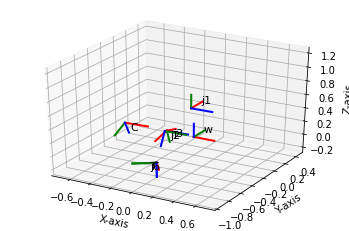

In [ ]:
# Visualize transform
visualize(joint_values)